In [54]:
# Imports Karpathy always has at the top of everything
import math
import numpy as np
import matplotlib.pyplot as plt

In [55]:
def f(x):
    return 3*x**2 - 4*x + 5

In [56]:
f(3.0)

20.0

In [57]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

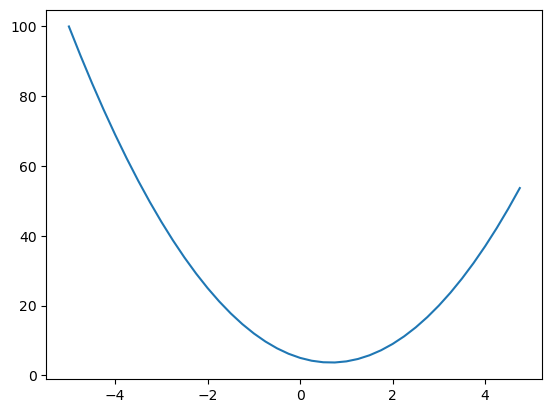

In [58]:
plt.plot(xs, f(xs))

In [59]:
h = 0.00000000001
x = 2/3
(f(x + h) - f(x)) / h
# at some point the slope is zero

0.0

In [60]:
# More complex case
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [61]:
# derivative of d with respect to individual values a, b, and c
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

# differential with respect to a becomes b (-3)
# differential with respect to b becomes a (2)
# differential with respect to c becomes 1 constant

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [111]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # default of 0 means changing this value does not change the output of this function
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    # special method to define operator for objects
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * self.data** (other - 1) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad 
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
d


#(a.__mul__(b)).__add__(c)


Value(data=4.0)

In [63]:
a = Value(2.0)
b = Value(4.0)
a - b
print(a-b)

Value(data=-2.0)


In [64]:
# Visualize expression graph
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
    
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

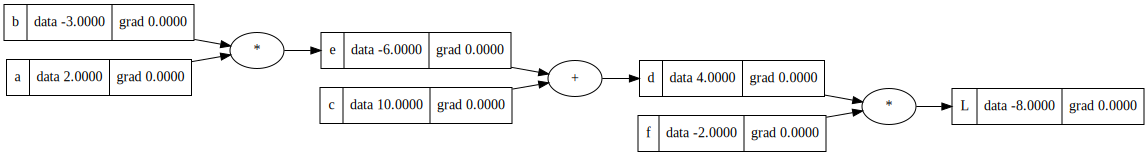

In [65]:
draw_dot(L)

In [66]:
# L = d * f
# #dL/dd = ?
# L2 = (d + h) * f = fd + fh
# L1 = d * f = fd
# L2 - L1 / h = (fd + fh - fd) / h = fh / h = f

# dL/df = ?

# L2 = d * (f + h) = df + dh
# L1 = d * f = df
# L2 - L1 / h = (df + dh - df) / h = dh / h = d

# #dL /dc = ??

# dL/dc = dL/dd * dd/dc
# dd/de = 1.0
# dd/dc = 1.0

# dd/dc 
# L2 = e + c + h
# L1 = e + c
# (L2 - L1) / h = ((e + c + h) - (e + c)) / h = h / h = 1

# plus nodes just route gradient because local derivative is 1.0



In [67]:
L.grad = 1.0
d.grad = -2
f.grad = 4
c.grad = -2
e.grad = -2
b.grad = -4
a.grad = 6

In [68]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f
print(L.data)

-35.549696


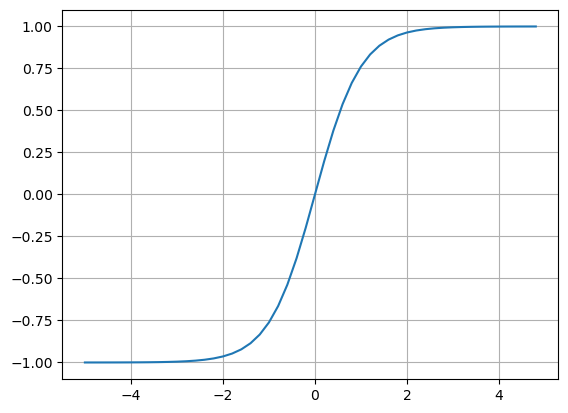

In [69]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

In [70]:
def lol():

    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='a')
    L = d * f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='a')
    L = d * f; L.label='L'
    L2 = L.data

    print((L2 - L1)/h)

lol()    

0.0


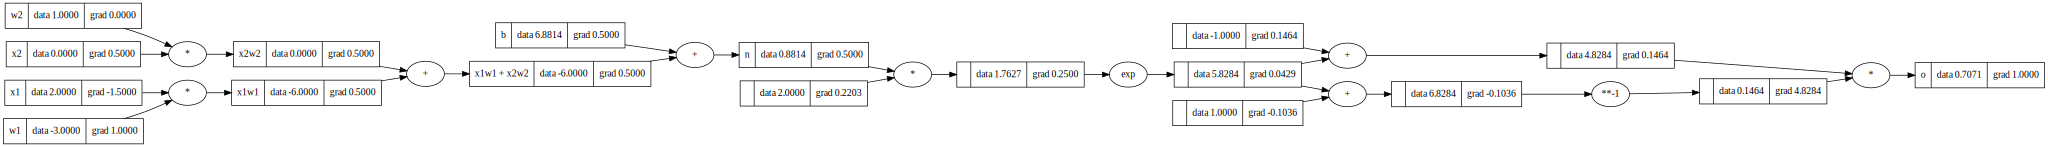

In [71]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# ------
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ------
o.label = 'o'
o.backward()
draw_dot(o)

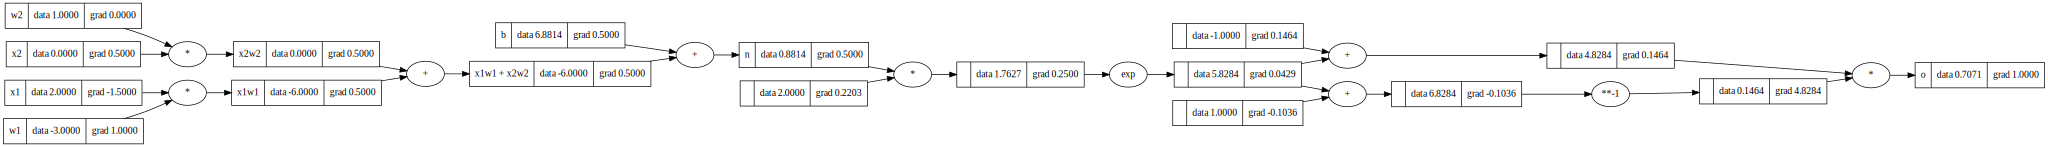

In [72]:
draw_dot(o)

In [73]:
#topological sort, process all the child nodes before processing yourself
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

for node in reversed(topo):
    node._backward()

In [74]:
o.grad = 1.0


In [75]:
o._backward()

In [76]:
n._backward()
b._backward()

In [77]:
x1w1x2w2._backward()

In [78]:
x1w1._backward()
x2w2._backward()

In [79]:
# w2.grad = x2.data * x2w2.grad
# x2.grad = w2.data * x2w2.grad
# w1.grad = x1.data * x1w1.grad
# x1.grad = w1.data * x1w1.grad

In [80]:
x2w2.grad = 0.5
x1w1.grad = 0.5

In [81]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [82]:
o.grad = 1.0
1 - o.data**2
n.grad = 0.5

In [83]:
# o = tanh(n)
# do / dn = 1 - tanh(o)**2 = 1 - o**2

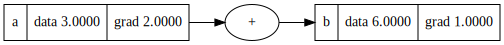

In [84]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

In [85]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

In [86]:
import torch

x1 = torch.Tensor([2.0]).double();              x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();              x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();             w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();              w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double();  b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [87]:
o.item()

0.7071066904050358

In [229]:
import random

class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    


In [230]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.38035311850997366)

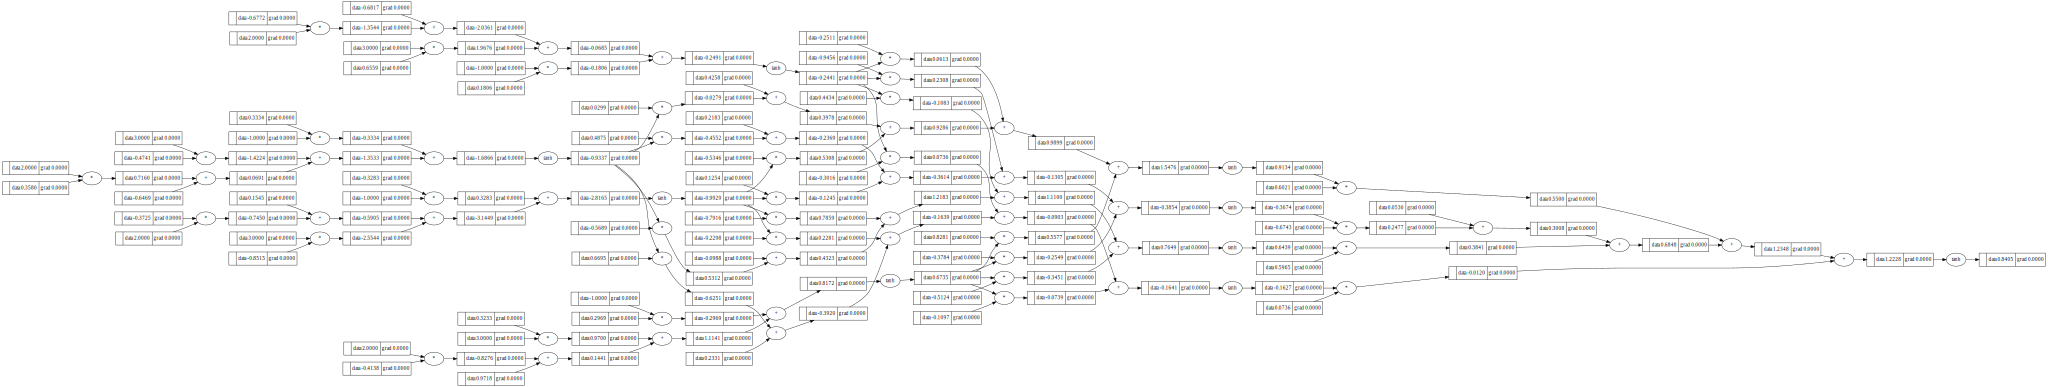

In [89]:
draw_dot(n(x))

In [231]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred

[Value(data=0.9999996145989553),
 Value(data=-0.9999999956692504),
 Value(data=-0.9999999956749465),
 Value(data=0.9999996168199464)]

In [241]:
# measures how well the neural net is performing, can square or abs to make sure you get a positive value
# only get zero when yout is == to ygt (y ground truth)

for k in range(20):

    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)
    

0 0.0038122168585776744
1 0.0037862597811965755
2 0.0037606418643947054
3 0.00373535658739429
4 0.00371039759436469
5 0.0036857586892629106
6 0.0036614338308657507
7 0.0036374171279858333
8 0.003613702834863129
9 0.0035902853467249837
10 0.0035671591955070254
11 0.0035443190457289057
12 0.0035217596905175175
13 0.003499476047772487
14 0.0034774631564672516
15 0.0034557161730808
16 0.00343423036815431
17 0.003413001122967888
18 0.00339202392633241
19 0.003371294371491947


In [242]:
ypred

[Value(data=0.9828336505971412),
 Value(data=-0.9786640803093493),
 Value(data=-0.9644559722791238),
 Value(data=0.9631487931811914)]